<a href="https://colab.research.google.com/github/thiennguyen37-qn/from-scratch-softmax/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FROM-SCRATCH SOFTMAX REGRESSION

## Import libraries

In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Helper Functions for Softmax Regression

 `tensor(x, dtype=torch.float32)`
- Converts input data into a **PyTorch tensor** with a specified data type.
- Ensures data type consistency during model training.

---

 `softmax(Z)`
- Applies the **Softmax function** to the linear output `Z`.
- Transforms logits into a **probability distribution** over classes.
- The probabilities for each sample sum to 1.


---

`loss_func(A, train_labels)`
- Computes the **Cross-Entropy Loss** for multi-class classification.
- Uses the predicted probability of the **true class** for each sample.
- Returns the **average loss** over the entire dataset.

---

`grad_loss(A, train_features, train_labels)`
- Computes the **gradient of the loss function** with respect to the weights `W` and bias `b`.
- Based on the simplified formulation of **Softmax combined with Cross-Entropy**.
- Used for parameter updates in **Gradient Descent from scratch**.

---

`predict(test_features, W, b)`
- Performs **forward propagation** on the test data.
- Applies Softmax to obtain class probabilities.
- Returns the **predicted class labels** by selecting the class with the highest probability.


In [2]:
def tensor(x,dtype = torch.float32):
  return torch.tensor(x, dtype = dtype)

def softmax(Z):
  return torch.exp(Z) / torch.sum(torch.exp(Z), dim = 1, keepdim = True)

def loss_func(A,train_labels):
  m = train_labels.shape[0]
  log_likelihood = -torch.log(A[range(m),train_labels])
  loss = torch.sum(log_likelihood) / m
  return loss

def grad_loss(A,train_features,train_labels):
  m = train_features.shape[0]
  grad_z = A.clone()
  grad_z[range(m),train_labels] -= 1
  grad_w = torch.matmul(grad_z.T,train_features) / m
  grad_b = torch.sum(grad_z, dim = 0) / m
  return grad_w, grad_b

def predict(test_features,W,b):
  Z = torch.matmul(test_features, W.T) + b
  A = softmax(Z)
  predictions = torch.argmax(A, dim = 1)
  return predictions

## Data Preparation and Preprocessing

- The **Wine dataset** is loaded using `load_wine()` from `sklearn.datasets`.
- Feature matrix `X` and target labels `y` are extracted and converted into **PyTorch tensors**.

- The dataset is split into **training** and **testing** sets using an 80/20 ratio.
  - `random_state = 42` is used to ensure reproducibility.

- **Standardization** is applied to the feature data using `StandardScaler`:
  - The scaler is **fitted only on the training set** to avoid data leakage.
  - Both training and test sets are transformed to have zero mean and unit variance.

- The standardized features are converted back into **PyTorch tensors** for model training.

This preprocessing step ensures that all features are on a similar scale, which improves the stability and convergence speed of gradient-based optimization.


In [3]:
data = load_wine()
X = torch.tensor(data.data)
y = torch.tensor(data.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
X_train = tensor(scaler.fit_transform(X_train))
X_test = tensor(scaler.transform(X_test))

## Gradient Descent for updating parameters
The GD function implements gradient descent training for a softmax regression model from scratch. It initializes model parameters using Xavier initialization, performs forward propagation and manual gradient computation, and updates the weights using gradient descent. K-Fold cross-validation is employed to estimate training and validation errors at each epoch, while test loss is tracked to monitor generalization performance.

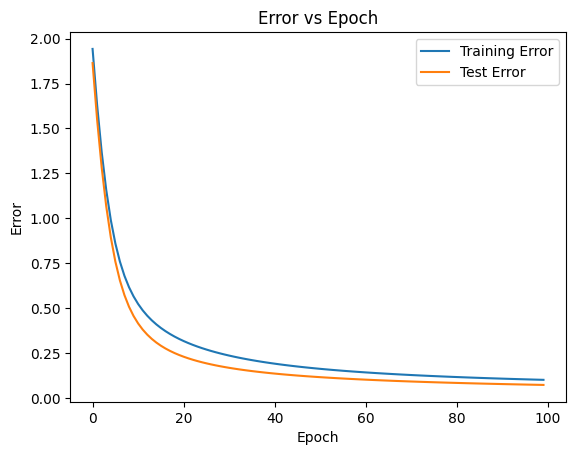

In [4]:
kf = KFold(n_splits = 4, shuffle = True, random_state = 42)

def GD(train_features,test_features,train_labels,test_labels,epochs,learning_rate):
  W = torch.nn.init.xavier_uniform_(torch.empty(3,13))
  b = torch.zeros(1,3)
  training_error = []
  validation_error = []
  test_error = []

  for epoch in range(epochs):
    loss_train = []
    loss_val = []

    for train_index, val_index in kf.split(train_features):
      X_train, X_val = train_features[train_index,:], train_features[val_index,:]
      y_train, y_val = train_labels[train_index], train_labels[val_index]
      loss_train.append(loss_func(softmax(torch.matmul(X_train,W.T) + b),y_train))
      loss_val.append(loss_func(softmax(torch.matmul(X_val,W.T) + b),y_val))

    loss_test = loss_func(softmax(torch.matmul(test_features,W.T) + b),test_labels)
    Z = torch.matmul(train_features,W.T) + b
    A = softmax(Z)
    grad_w, grad_b = grad_loss(A,train_features,train_labels)
    W -= learning_rate * grad_w
    b -= learning_rate * grad_b
    training_error.append(np.mean(loss_train))
    validation_error.append(np.mean(loss_val))
    test_error.append(loss_test)

  plt.plot(training_error, label = 'Training Error')
  plt.plot(test_error, label = 'Test Error')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.title('Error vs Epoch')
  plt.show()
  return W,b

W,b = GD(X_train,X_test,y_train,y_test,100,0.1)

## FINAL RESULT

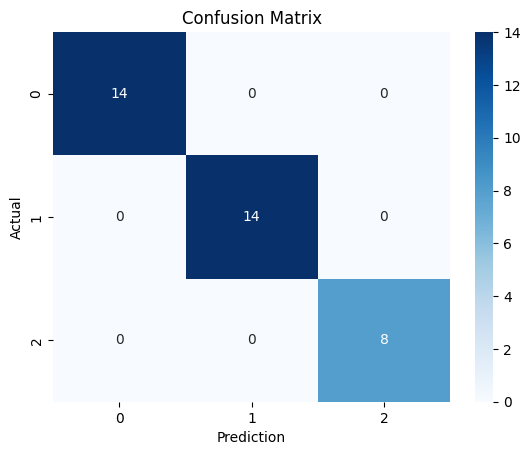

In [5]:
y_pred = predict(X_test,W,b)
sb.heatmap(confusion_matrix(y_test,y_pred), annot = True, cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()